In [7]:
!pip install opencv-python

In [721]:
from matplotlib import pyplot as plt
import numpy as np
import argparse
import cv2
import math

# Data Analysis ( Again )

<p> I decided to look into the data again, I converted the image into GRAYSCALE and produced a colour histogram for it, I compared several of these histograms and noticed that the majority of the rich images have similar histograms as seen below </p>

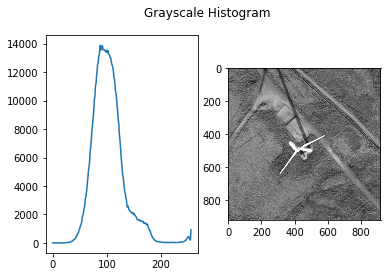

In [772]:
img = cv2.imread('ImageData/1108721011.jpeg')
#img = cv2.imread('ImageData/514389187.jpeg')
#img = cv2.imread('ImageData/1359314982.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
img2 = img

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Grayscale Histogram")
ax1.plot(hist)
ax2.imshow(gray,"gray")

# Image segmentation

<p> As the rich images all have similar histograms I decided to see the result of thresholding the image so that only bins with a value of 200 or over are left white. This test was intially successful but required some bluring and denoising to work as well as it has below</p>

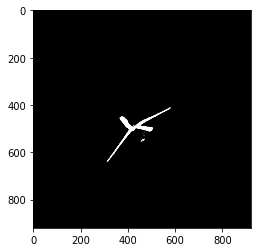

In [773]:
ret,thresh1 = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)
thresh1 = cv2.fastNlMeansDenoising(thresh1,None,10,7,21)
blur = cv2.medianBlur(cv2.GaussianBlur(thresh1,(3,3),0),7)
plt.imshow(blur,"gray")

## All about lines

<p> Now that I have isolated the wind turbine from the background, I decided that if I could find a way to automatically find a line that best fits the orientation of the turbine. Lastly I would have to figure out which way its actually facing and produce a bearing</p>

In [774]:
lines = cv2.HoughLines(blur,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + img.shape[0]*(-b))
    y1 = int(y0 + img.shape[0]*(a))
    x2 = int(x0 - img.shape[0]*(-b))
    y2 = int(y0 - img.shape[0]*(a))

    #cv2.line(img,(x1,y1),(x2,y2),(0,0,255),5)
A = (x1,y1)
B = (x2,y2)

<p> One could ask why I chose to go for Hough immediatiley, thats because its the first thing that came to mind. I recalled that in my computer vision module we studied a proccess where lines were generated across the screen and a voting system decided which line stays and which one goes. Admitedly I had to go over some of my old lecture notes to jog my memory.
</p>

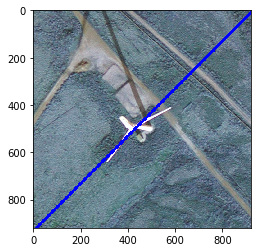

In [775]:
cv2.line(img,A,B,(0,0,255),10)
#cv2.line(img,closest_line[0],closest_line[1],(255,255,0),5)
plt.imshow(img)

<p> Now its time to find the back of the wind turbine. I used HoughLinesP this time as it returned a variety of lines to work with. 
My for loop returns the new line which has the closest angle to 90deg against the original line. The reason for this is that I noticed the back of the wind turbine is almost always nearly 90deg from my orientation line. This I tested against several images. </p>

In [776]:
lines2 = cv2.HoughLinesP(blur, 1, np.pi/180, 50, minLineLength=0, maxLineGap=15)
closest_angle = 0
closest_line = ((0,0),(0,0))
for e in lines2:
    C = (e[0][0],e[0][1])
    D = (e[0][2],e[0][3])
    angle = ang((A,B), (C, D))
    if (abs(closest_angle - 90) > abs(angle-90)):
        closest_angle = angle
        closest_line = C,D

<p> This method seemed to work well with rich photos, but less so with poor ones. I did not test this with every photo but rather a small sample of photos, mainly rich ones. </p> 

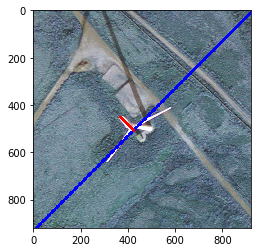

In [777]:
cv2.line(img,closest_line[0],closest_line[1],(255,0,0),10)
plt.imshow(img)

# Calculating the bearing

<p> I inteded to implement methods which would calculate the bearing of the wind turbine with all the information I have gathered from my previous work, I had a few disruptions this weekend which didn't give me the time that I wanted to spend on this problem. However My thoughts on the implementation of this will actually borrow from what I have already done. If using the Image above as an example I know the general orientation to draw a "Bearing Line" and also due to the red line I also know which side of the blue line to draw the "Bearing Line". The method line_intersection can return the intersection point between the red and blue line. Our new bearing line can begin at this intersection and run away from the red line. Once This "Bearing Line" has been created I can reuse the ang method to find the angle between our new "Bearing Line" and the top of the Image which could be represent by a vector (p1x, p1y) = intersection line previously calculated. (p2x, p2y) = p1x and 0. This would return the bearing of the wind turbine.</p>

In [771]:
#source : https://stackoverflow.com/questions/28260962/calculating-angles-between-line-segments-python-with-math-atan2

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 

        return ang_deg

In [ ]:
#https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

print line_intersection((A, B), (C, D))